In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from tqdm import tqdm_notebook

In [231]:
def draw_path(path, points, cost):
    fig, ax = plt.subplots(figsize=[12, 10])
    x_ax = []
    y_ax = []
    for i in range(len(path)-1):
        curr_p = points[path[i]]
        next_p = points[path[i+1]]
        x_ax += [curr_p[0], next_p[0]]
        y_ax += [curr_p[1], curr_p[1]]
    x_ax += [next_p[0]]
    y_ax += [next_p[1]]
    ax.plot(x_ax, y_ax, label=f'Path length = {cost}', alpha=0.8)
    ax.scatter(points[path][:, 0], points[path][:, 1], c='r')
    ax.legend()
    ax.grid()

class Individual:
    
    def __init__(self, path, cost):
        self.path = path
        self.cost = cost
    
    def mutate(self, p):
        for i in range(len(self.path) - 1):
            if np.random.rand() <= p:
                self.path[i], self.path[i+1] = self.path[i+1], self.path[i]
                
    def ger_comp_chrom(self, chrom):
        comp_mask = np.full(len(self.path), False)
        for i in range(len(self.path)):
            if self.path[i] not in chrom:
                comp_mask[i] = True
        return comp_mask
                
    def __del__(self):
        del self.path
        del self.cost
    
class Population(list):
    
    def __init__(self, n, size, dmat, p):
        from itertools import combinations
        self.dmat = dmat
        self.n = n
        self.p = p
        self.c_list = list(combinations(range(n), 2))
        self.cross_dist = np.array([y-x for x,y in combinations(range(n), 2)])
        self.cross_dist = np.abs(self.cross_dist - self.n/2)
        self.cross_dist = np.abs(self.cross_dist - np.max(self.cross_dist))
        self.cross_dist = self.cross_dist/np.sum(self.cross_dist)
        for _ in range(size):
            path = np.random.permutation(n)
            cost = self.eval_indiv(path)
            self.append(Individual(path, cost))
            
    def eval_indiv(self, path):
        return self.dmat[path[:-1], path[1:]].sum()
    
    def breed(self, n_best, n_child, permute):
        from random import shuffle
        temp = []
        if permute:
            temp_i = list(range(n_best))
            shuffle(temp_i)
            index = []
            for i in range(0, len(temp_i), 2):
                index.append((temp_i[i], temp_i[i+1]))
        else:
            index = ((i, i+1) for i in range(0, n_best, 2))
        for i1, i2 in index:
            for _ in range(0, n_child, 2):
                self.make_child(i1, i2, temp)
                self.make_child(i2, i1, temp)
        self[n_best:] = temp
    
    def make_child(self, i1, i2, arr):
        child = np.zeros(self.n)
        fill_mask = np.full(self.n, False)
        
        ind = np.random.choice(len(self.c_list), 1, p=self.cross_dist)
        ind = self.c_list[ind[0]]
        chrom1 = self[i1].path[ind[0]:ind[1]]
        fill_mask[ind[0]:ind[1]] = True
        child[fill_mask] = chrom1
        comp_mask = self[i2].ger_comp_chrom(chrom1)
        child[np.logical_not(fill_mask)] = self[i2].path[comp_mask]
        child = child.astype(int)
        child = Individual(child, self.eval_indiv(child))
        child.mutate(self.p)
        arr.append(child)
    
    def sort(self):
        super().sort(key=lambda x: x.cost)
        
    def print_(self):
        for x in self:
            print(x.cost)
    
    def __del__(self):
        for x in self:
            del x
    
class Selection:
    
    def __init__(self, init_size, n_child, n_best, permute_best, n_iter, p=0.05):
        '''
        init_size: size of the initial population
        n_child: number of children each pair of parents produce during breeding
        n_best: number of pairs of individuals selected to breed
        permute_best: whether best individuals choose breeding partner randomly
        n_iter: number of generations
        '''
        self.init_size = init_size
        self.n_child = n_child
        self.n_best = n_best
        self.permute_best = permute_best
        self.n_iter = n_iter
        self.p = p
        
    def train(self, dmat):
        self.cost_arr = []
        self.n = dmat.shape[0]
        self.population = Population(self.n, self.init_size, dmat, self.p)
        for _ in tqdm_notebook(range(self.n_iter)):
            self.population.sort()
            self.cost_arr.append(self.population[0].cost)
            self.population.breed(self.n_best, self.n_child, self.permute_best)
        self.population.sort()
        return self.population[0]

In [228]:
cities = np.genfromtxt('Data/tsp.csv', delimiter=',')[:,1:]
dmat = distance_matrix(cities, cities, p=1)

In [268]:
S = Selection(init_size=300, n_child=20, n_best=120, permute_best=True, n_iter=100, p=0.1)

In [269]:
best = S.train(dmat)

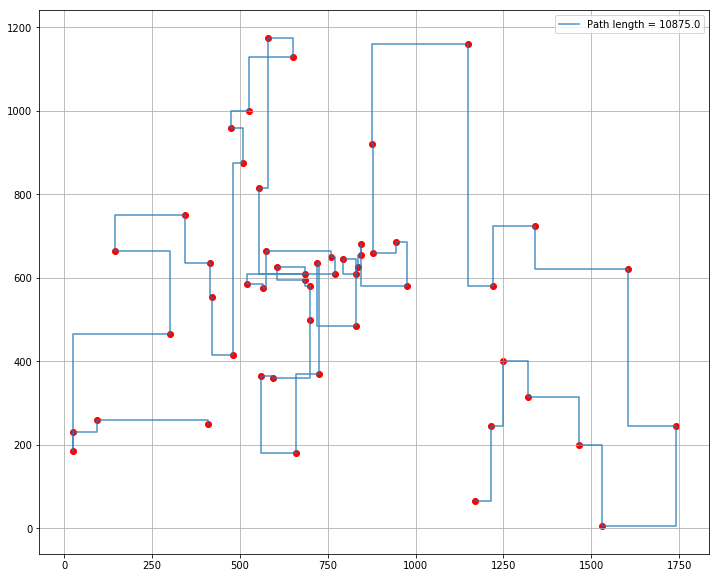

In [270]:
draw_path(best.path, cities, best.cost)

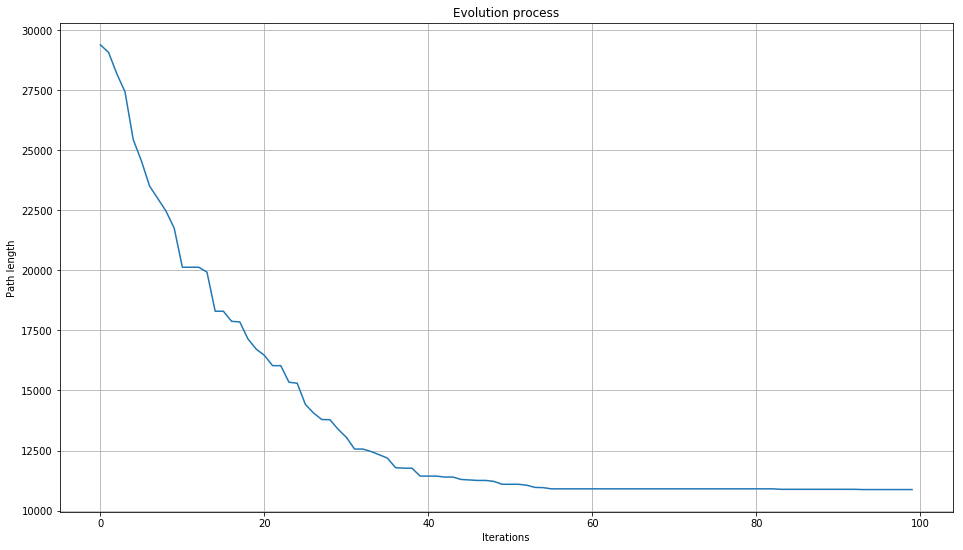

In [271]:
fig, ax = plt.subplots(figsize=[16, 9])
ax.set_xlabel('Iterations')
ax.set_ylabel('Path length')
ax.set_title('Evolution process')
ax.plot(S.cost_arr)
ax.grid()